In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [12]:
#Load the dataset, take a look at the data info: 
df_1 = pd.read_csv('Data/DF_1_clean.csv')
df_1.set_index('Date', inplace=True)
df_2 = pd.read_csv('Data/DF_2_clean.csv')
df_2.set_index('Date', inplace=True)
df_3 = pd.read_csv('Data/DF_3_clean.csv')
df_3.set_index('Date', inplace=True)

# Resort 1

### First Simple Model
Linear Regression with Cross Validation: 

In [17]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
y.head()

Date
2017-12-21    432.0
2017-12-22     48.0
2017-12-23    266.0
2017-12-24    283.0
2017-12-25    281.0
Name: TOTAL_VISITS, dtype: float64

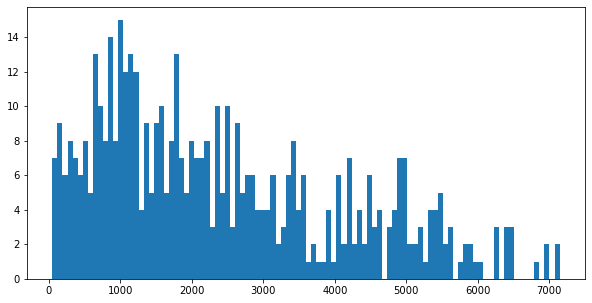

In [9]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);


In [22]:
#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(LRPipe, X_train, y_train, cv = 3)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.0324769 , 0.02553225, 0.02359891]), 'score_time': array([0.01517701, 0.02217674, 0.01897621]), 'test_score': array([0.35521544, 0.44897868, 0.44931362]), 'train_score': array([0.55955406, 0.51543235, 0.5481807 ])}
mean CV Score: 0.41783591380107216


With Encoding and scaling, the Basic Linear Regression CV score is 0.418

There is definitly some room for improvement! 

## Tree Regressor

In [28]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)
cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

dtr = DecisionTreeRegressor(random_state=42)

TreeRegPipe = Pipeline([('trans', Transformer),
                        ('dtr', dtr)])

dtr_param_grid = {
	'dtr__splitter': ['best', 'random'],
    'dtr__min_samples_split': [4, 6, 8, 10],
    'dtr__max_depth': [4, 5, 6, 7, 8]
}		

#set up gridsearch:
TreeGrid = GridSearchCV(estimator=TreeRegPipe,
						  param_grid=dtr_param_grid,
						  cv=3)

TreeGrid.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(TreeGrid, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(TreeGrid, X_train, y_train, cv = 3)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(TreeGrid.best_params_)

print(f'Tree Grid Cross Validation Scores: {cv}')

print(f'Tree Grid mean CV Score: {cv_score.mean()}')

Best Parameter Combination for Tree Regressor Found During Grid Search:
{'dtr__max_depth': 7, 'dtr__min_samples_split': 10, 'dtr__splitter': 'best'}
Tree Grid Cross Validation Scores: {'fit_time': array([1.7129879 , 1.77686095, 1.69458604]), 'score_time': array([0.00824189, 0.0036962 , 0.00476289]), 'test_score': array([0.43429782, 0.47071407, 0.28483747]), 'train_score': array([0.88152865, 0.83650799, 0.82616951])}
Tree Grid mean CV Score: 0.39661645429417974


Tree Regressor did not perform well with the best score of .397 in comparison to linear regression with a score of .418

## Random Forests 

In [29]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

# #Split into test and train X and Y
# X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
# y = df_3_preprocessed['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=3)

#fit gridsearch
gridsearch2.fit(X_train, y_train)


print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)

Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mae', 'dtr__max_depth': None, 'dtr__max_features': 'auto', 'dtr__n_estimators': 10}


In [36]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(criterion = 'mae', max_depth = None, max_features = 'auto', n_estimators = 10, random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])


pipeline_3.fit(X_train, y_train)

cv = cross_validate(pipeline_3, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_3, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores best Random Forest Regressor: {'fit_time': array([0.10468078, 0.10215998, 0.10118198, 0.11714292, 0.10317492]), 'score_time': array([0.008425  , 0.00471592, 0.00667   , 0.00649691, 0.00496221]), 'test_score': array([0.57028451, 0.64140287, 0.7529616 , 0.68577996, 0.42613841]), 'train_score': array([0.93575578, 0.91772552, 0.91531086, 0.91971138, 0.91446831])}
mean CV Score: 0.61531347043847


For Resort 1, forests are performing better than trees with a CV score of .615!

## Gradient Boosting: 

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

print("Best Parameter Combination Found During Gradient Boosting Grid Search:")
print(gridsearch3.best_params_)


Best Parameter Combination Found During Gradient Boosting Grid Search:
{'gbr__criterion': 'friedman_mse', 'gbr__min_samples_split': 3, 'gbr__n_estimators': 100}


In [35]:
#Using best params on a gradient booster regressor then scoring thorugh cross val: 

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
# GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, random_state = 42)
GBR = GradientBoostingRegressor(criterion='friedman_mse', n_estimators=100, min_samples_split= 3, random_state = 42)

#pipeline
pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_gbr.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Score Gradient Boosting Model: {'fit_time': array([0.09019113, 0.06526279, 0.06683993, 0.06603694, 0.08423114]), 'score_time': array([0.00608301, 0.00390124, 0.00385904, 0.004812  , 0.00417709]), 'test_score': array([0.64582103, 0.72973226, 0.72184128, 0.7821154 , 0.64737244]), 'train_score': array([0.92685098, 0.92960816, 0.92977908, 0.91711137, 0.93585572])}
mean CV Score: 0.705376480997786


### Gradient Booster Regressor is doing the best: 

And more improvement! We got our average model CV score up to .705

In [37]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#x_boost Pipe:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer

cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_boost.best_params_)

Best Parameter Combination Found During Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 3}


In [38]:
#x_boost Pipe with ideal paramaters:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer
cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_2 = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboostPipe_2 = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_2)])

xboostPipe_2.fit(X_train, y_train)

cv = cross_validate(xboostPipe_2, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboostPipe_2, X_train, y_train, cv = 5)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.10541511, 0.05193114, 0.04159904, 0.04817104, 0.04404402]), 'score_time': array([0.00847983, 0.01229191, 0.01034975, 0.00830412, 0.0126729 ]), 'test_score': array([0.60579381, 0.73290358, 0.72137846, 0.81642227, 0.64039896]), 'train_score': array([0.95982675, 0.96375075, 0.96609444, 0.96010115, 0.96666743])}
mean CV Score: 0.7033794159155814


X boost for resort 1 is preforming about the same as the Gradient Booster Regressor

## Evaluation

**Gradient Booster Regressor** 

CV score up to .72

In [39]:
#GBR Test Score
pipeline_gbr.score(X_test, y_test)

0.7738167530522504

Gradient Booster Regressor gets a test CV score of .774, this means we can account for 77% of the variance in the data with our Gradient Booster Regressor model. 

In [40]:
y_pred_boost = pipeline_gbr.predict(X_test)

df = pd.DataFrame({'Real Visits':y_test, 'Predicted Visits':y_pred_boost, 'Difference': abs(y_test - y_pred_boost)})
df.head()


,Real Visits,Predicted Visits,Difference
Date,,,
2021-02-07,4612.0,4421.515130,190.484870
2021-04-04,887.0,1718.004963,831.004963
2019-02-20,2769.0,2917.148642,148.148642
2021-03-07,4072.0,2935.819651,1136.180349
2020-01-27,1393.0,1853.388422,460.388422


In [41]:
df['Difference'].mean()

680.7975932095176

In [42]:
for name, importance in zip(X_train.columns, pipeline_gbr['gbr'].feature_importances_):
    print(name, importance)

is_school_out 0.025351575103521214
is_holiday 0.044095493823134074
T - AWND 0.0078595078668822
T - PRCP 0.002770315723362899
T - SNOW 0.003630304218622402
T - SNWD 0.015046849206457756
T - TAVG 0.0008085034731838031
M_PRCP 0.00018606127178336004
M_SNWD 0.024309256917961996
M_TAVG 0.16566395836282116
day_of_week_num 0.1661238930660503
month 0.033529529612692566


In [43]:
ohe = pipeline_gbr.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, pipeline_gbr['gbr'].feature_importances_):
    print(name, importance)


x0_0 0.025351575103521214
x0_1 0.044095493823134074
x1_0 0.0078595078668822
x1_1 0.002770315723362899
x2_0 0.003630304218622402
x2_1 0.015046849206457756
x2_2 0.0008085034731838031
x2_3 0.00018606127178336004
x2_4 0.024309256917961996
x2_5 0.16566395836282116
x2_6 0.1661238930660503
T - AWND 0.033529529612692566
T - PRCP 0.00670711305094752
T - SNOW 0.02912046300665862
T - SNWD 0.0077716566739196745
T - TAVG 0.08672645724291084
M_PRCP 0.0064209374777957785
M_SNWD 0.17026598560975334
M_TAVG 0.04147328876189428


IndexError: index 19 is out of bounds for axis 0 with size 19

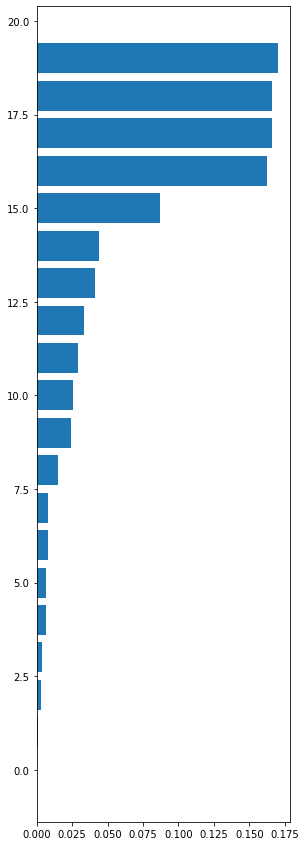

In [44]:
from sklearn.inspection import permutation_importance

feature_importance = pipeline_gbr['gbr'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    pipeline_gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()